# 範例重點
學習如何在 keras 中撰寫自定義的 loss function <br />
知道如何在訓練時使用自定義的 loss function

In [1]:
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input
import keras
import matplotlib.pyplot as plt

!nvidia-smi

Using TensorFlow backend.


Thu Jul 25 23:40:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten :
    x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes = 10):
  
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
train_y = preproc_y(train_y)

test_x = preproc_x(test_x)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  
  input_layer = Input(input_shape, name = "main_input")
  
  for i, n_neuron in enumerate(num_neurons):
    if i == 0 :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(input_layer)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
    else :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      
  output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output") (x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model  

In [0]:
lr = 1e-3
momentum = 0.95
#Large batch size will overfit easily
batch_size = 1024
epochs = 50

In [0]:
import tensorflow as tf
import keras.backend as k

def focal_loss(gamma=2., alpha = 4.):
  gamma = float(gamma)
  alpha = float(alpha)
  
  def focal_loss_fixed(y_true, y_pred):
    #Focal loss for multi-classification
    #FL(pt) = - alpha(1-pt)^(gamma) * ln(pt)
    
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
    model_out = tf.add(y_pred, epsilon)
    #crossentropy
    #ce = sum( -yi_true * log2(yi_pred) )
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1.0, model_out) , gamma))
    f1 = tf.multiply(alpha, tf.multiply(weight, ce))
    
    #get the maximum value in tensor
    reduced_f1 = tf.reduce_max(f1, axis = 1)
    return tf.reduce_mean(reduced_f1)
  
  return focal_loss_fixed

In [15]:
model = build_mlp(train_x.shape[1:], 10)
optimizer = keras.optimizers.SGD(lr = lr, momentum = momentum, nesterov = True)
model.compile(optimizer = optimizer, loss = focal_loss() , metrics = ["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
__________

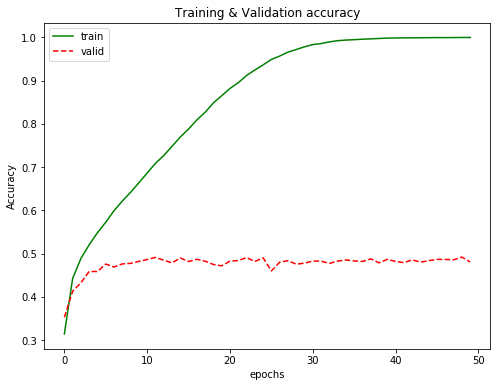

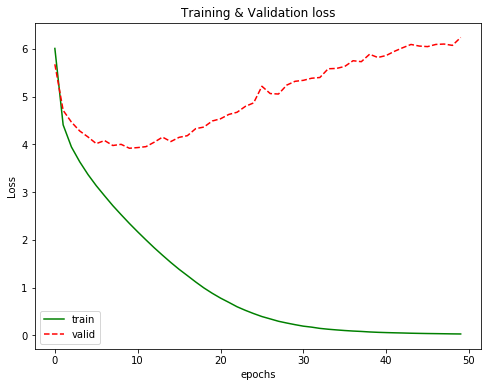

In [16]:
plt.figure(figsize = (8,6))
plt.plot(history.history['acc'],'-', label = "train", color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid', color = 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'],'-', label = "train", color = 'g')
plt.plot(history.history['val_loss'],'--', label = "valid", color = 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training & Validation loss")
plt.legend()
plt.show()

# Work
請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [0]:
def mylossfn(focal_w = 0.3, ce_w = 0.7, gamma = 2., alpha = 4.):
  
  def focal_crossentropy_loss(y_true, y_pred):
    
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
    #add epsilon avoid 0 val in y_pred
    y_pred = tf.add(y_pred, epsilon)
    #crossentropy
    ce = tf.multiply(y_true, -tf.log(y_pred))
    
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1.0, y_pred), gamma))
    fl = tf.multiply(alpha , tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis = 1)
    reduced_ce = tf.reduce_max(ce, axis = 1)
    
    mean_fl = tf.reduce_mean(reduced_fl)
    mean_ce = tf.reduce_mean(reduced_ce)
    
    return focal_w * mean_fl + ce_w*mean_ce
  
  return focal_crossentropy_loss

In [26]:
model = build_mlp(train_x.shape[1:])
model.compile(optimizer = optimizer, loss = mylossfn() , metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0         
__________

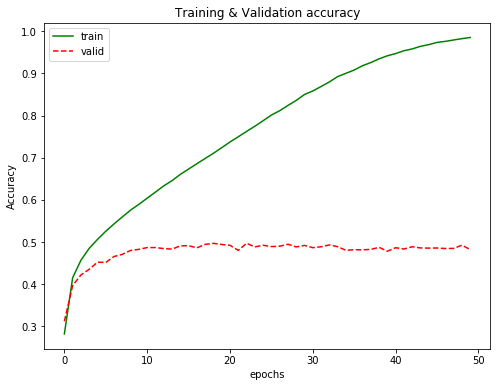

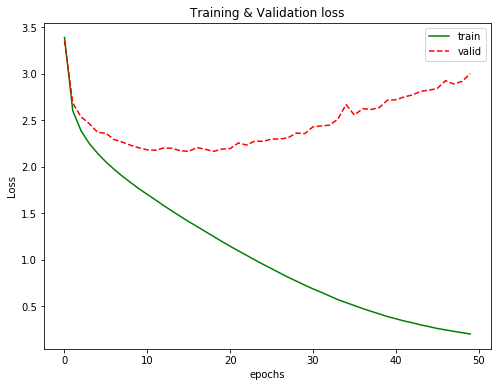

In [27]:
plt.figure(figsize = (8,6))
plt.plot(history.history['acc'],'-', label = "train", color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid', color = 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'],'-', label = "train", color = 'g')
plt.plot(history.history['val_loss'],'--', label = "valid", color = 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training & Validation loss")
plt.legend()
plt.show()